[View in Colaboratory](https://colab.research.google.com/github/gitgash/ds-test/blob/master/ann_estimator.ipynb)

# Introduction
This work have been proceed as test job for data scientist position.  
Requirements:  
get [data](https://www.dropbox.com/s/tzb7mjxipz8fnyt/dataset.csv?dl=1) and make estimator with highest f1 metric.  
During  this work it have been done: 
1. data exploration,
1. 'traditional' model creation 
1. artificial neural network model creation.

Results considered in conclusion section.  
Google (tm) [Colab.research](https://colab.research.google.com) have been used in this work, but methodology and technology (jupyter notebook) tools can be used in any suitable environment (python, scikit learn, pandas, numpy, tensorflow, keras).  
Style of the work is reproducible  - anybody can run this notebook and reproduce results.  
So lets start.

# Data Exploration
In process of data exploration following steps have been proceed:
1. Loading data
1. Simple exploration
1. Correlation analysis


## Load data
Data file have been place to dropbox so we load them from there by url.

In [1]:
# It is preleminary section where we include part of libraries used later 
# and define utility functions
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools


# Plot confision matrix function
# (c) by scikit lear documentation and examples
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Using TensorFlow backend.


We use side library to upsample imbalanced test set (later explained) - so we need to install it:

In [2]:
!pip install -U imbalanced-learn

    100% |████████████████████████████████| 153kB 8.6MB/s 


In [0]:
# load dataset into pandas dataframe

df = pd.read_csv("https://www.dropbox.com/s/tzb7mjxipz8fnyt/dataset.csv?dl=1")


## Simple data exploration

In [3]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28125 entries, 0 to 28124
Columns: 1367 entries, id to label
dtypes: float64(1365), int64(1), object(1)
memory usage: 293.3+ MB


,id,f1_avg__r0,f1_stddev__r0,f1_min__r0,f1_max__r0,f2_avg__r0,f2_stddev__r0,f2_min__r0,f2_max__r0,f3_avg__r0,...,f21_q1__r4,f21_q2__r4,f21_q3__r4,f21_q4__r4,f21_q5__r4,f21_q6__r4,f21_q7__r4,f21_q8__r4,f21_q9__r4,label
0,0134cd2e-967e-3f2f-5caa-3c450b0d8e1f,46731.346682,12910.739495,3275.0,110294.0,23.220351,13.563847,1.0,97.0,336.262593,...,28.0,28.0,29.0,29.0,30.0,31.0,32.0,33.0,35.0,5
1,0535a308-9f59-1e84-df14-5f397b78a533,24407.149135,6813.252353,1581.0,55594.0,45.657840,15.581942,2.0,93.0,9.803859,...,31.0,31.0,31.0,32.0,32.0,33.0,34.0,35.0,37.0,2
2,0720d3fe-4704-4134-1898-6d13f684bb07,43740.310576,27911.289581,5269.0,101494.0,27.246934,13.236147,2.0,68.0,555.363925,...,30.0,30.0,30.0,31.0,31.0,32.0,32.0,33.0,35.0,2
3,08d76ab6-4a79-ac3d-60dc-c0cb7fdad4bc,44401.760364,5946.347073,9928.0,50981.0,30.278484,10.435464,1.0,83.0,58.922971,...,30.0,30.0,30.0,31.0,31.0,31.0,32.0,32.0,33.0,5
4,09421104-0203-4538-bc59-e8a08b6b2d4a,15417.934109,6817.671320,5793.0,59615.0,7.046253,9.115563,2.0,75.0,2.379845,...,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,5


28125 examples -  not very good for deep learning  
It looks that we have id with unique  id of object and label in the end.  
1367 columns, 1 - id, 1 - label so we have 1365 features.  
Features are float and integer  
Lets look on the features: 

In [6]:
# Looking for names
for s in df.columns[1:-1]:
    print("%s\t%d" % (s, df[s].count()))

f1_avg__r0	28125
f1_stddev__r0	28125
f1_min__r0	28125
f1_max__r0	28125
f2_avg__r0	28125
f2_stddev__r0	28125
f2_min__r0	28125
f2_max__r0	28125
f3_avg__r0	28125
f3_stddev__r0	28125
f3_min__r0	28125
f3_max__r0	28125
f4_avg__r0	28125
f4_stddev__r0	28125
f4_min__r0	28125
f4_max__r0	28125
f5_avg__r0	28125
f5_stddev__r0	28125
f5_min__r0	28125
f5_max__r0	28125
f6_avg__r0	28125
f6_stddev__r0	28125
f6_min__r0	28125
f6_max__r0	28125
f7_avg__r0	28125
f7_stddev__r0	28125
f7_min__r0	28125
f7_max__r0	28125
f8_avg__r0	28125
f8_stddev__r0	28125
f8_min__r0	28125
f8_max__r0	28125
f9_avg__r0	28125
f9_stddev__r0	28125
f9_min__r0	28125
f9_max__r0	28125
f10_avg__r0	28125
f10_stddev__r0	28125
f10_min__r0	28125
f10_max__r0	28125
f11_avg__r0	28125
f11_stddev__r0	28125
f11_min__r0	28125
f11_max__r0	28125
f12_avg__r0	28125
f12_stddev__r0	28125
f12_min__r0	28125
f12_max__r0	28125
f13_avg__r0	28125
f13_stddev__r0	28125
f13_min__r0	28125
f13_max__r0	28125
f14_avg__r0	28125
f14_stddev__r0	28125
f14_min__r0	28125
f14_

Column names looks composed from 'fX' ' and 'rX'  
s 'f' counts from 1 to 21, 'r' counts from 1 to 4 and functions are: avg, min, max, stddev and qX (X from 1-9)   May be fX and rX are sequence identifiers and functions in between are some functions over this sequences  (hypothesis)  
No NaN values in columns.   
What about labels?  

count    28125.000000
mean         3.973689
std          1.273402
min          1.000000
25%          3.000000
50%          4.000000
75%          5.000000
max          5.000000
Name: label, dtype: float64


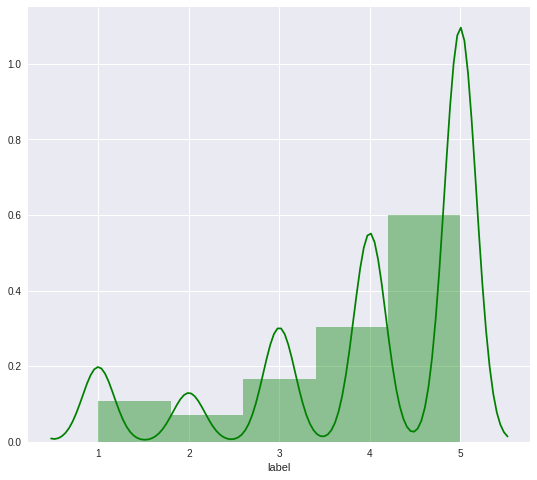

In [7]:
print(df['label'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(df['label'], color='g', bins=5, hist_kws={'alpha': 0.4});

Labels is strongly imbalanced: class '5' prevails over others.  
distribution over classes looks like left part of normal distribution with mean on '5'.  

# Correlation analisys

In [15]:
# calculate correlation matrix and get 'label' correlation column
df_num_corr = df.corr()['label'][:-1]
# get absolute value of correlation
abs_corr = abs(df_num_corr)
# sort and get top 20
abs_corr.sort_values(ascending=False).head(20)

f7_avg__r1     0.226838
f7_avg__r0     0.226745
f11_avg__r0    0.225283
f11_avg__r1    0.225230
f7_q2__r0      0.224088
f7_q3__r0      0.223948
f7_q2__r1      0.223854
f7_q3__r1      0.223776
f7_q4__r0      0.223102
f7_q4__r1      0.222957
f7_min__r3     0.221392
f7_q1__r3      0.221008
f7_q5__r1      0.220252
f7_q1__r0      0.220136
f7_max__r2     0.220128
f7_q2__r3      0.220018
f7_q5__r0      0.219952
f7_avg__r3     0.219930
f7_q4__r3      0.219743
f7_q5__r3      0.219632
Name: label, dtype: float64

0.22 is not very strong correlation and most of top correlated features is f7_XXX  
Possible it means that we have f7 feature that correlated with label and all f7 derivatives dont add something to classification model.  
What about not correlated features?

In [16]:
no_corr_list = abs_corr[abs_corr.isna()].index.values.tolist()
no_corr_list

['f8_min__r0',
 'f10_min__r0',
 'f18_min__r0',
 'f10_q1__r0',
 'f10_q2__r0',
 'f10_q3__r0',
 'f10_q4__r0',
 'f10_q5__r0',
 'f10_q6__r0',
 'f18_q1__r0',
 'f18_q2__r0',
 'f18_q3__r0',
 'f18_q4__r0',
 'f18_q5__r0',
 'f18_q6__r0',
 'f18_q7__r0',
 'f18_q8__r0',
 'f18_q9__r0',
 'f18_min__r1',
 'f8_min__r2',
 'f10_avg__r2',
 'f10_stddev__r2',
 'f10_min__r2',
 'f10_max__r2',
 'f18_avg__r2',
 'f18_stddev__r2',
 'f18_min__r2',
 'f18_max__r2',
 'f10_q1__r2',
 'f10_q2__r2',
 'f10_q3__r2',
 'f10_q4__r2',
 'f10_q5__r2',
 'f10_q6__r2',
 'f10_q7__r2',
 'f10_q8__r2',
 'f10_q9__r2',
 'f18_q1__r2',
 'f18_q2__r2',
 'f18_q3__r2',
 'f18_q4__r2',
 'f18_q5__r2',
 'f18_q6__r2',
 'f18_q7__r2',
 'f18_q8__r2',
 'f18_q9__r2',
 'f10_avg__r3',
 'f10_stddev__r3',
 'f10_min__r3',
 'f10_max__r3',
 'f18_avg__r3',
 'f18_stddev__r3',
 'f18_min__r3',
 'f18_max__r3',
 'f10_q1__r3',
 'f10_q2__r3',
 'f10_q3__r3',
 'f10_q4__r3',
 'f10_q5__r3',
 'f10_q6__r3',
 'f10_q7__r3',
 'f10_q8__r3',
 'f10_q9__r3',
 'f18_q1__r3',
 'f18_q2_

It looks that f18 and f10 with derivatives not correlated with label

# Build Estimators

## Quality
'f1' metric stated as target metric for this work.  
There are 2 questions regarding this metric:
1. What kind of f1 metric must be chosen for multiclass classification
1. What is 'good' and what is 'bad' for given f1 value

Scikit learn provide several types of f1 metric. 2 types are good candidates to use: 'macro' and 'weighted'.  
Macro metric description  from documentation: "Calculate metrics globally by counting the total true positives, false negatives and false positives.". So macro is 'objective' metric that provide information how good is estimator for any given class - no meter  of how often this class in dataset.  
Weighted metric: "Calculate metrics for each label, and find their average, weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.". This metric give more full representation - taking in account number of right answers.  
What metric is better? For the first look weighted is good candidate but for imbalance set (our case) it can produce wrong estimation. For example if we have strongly imbalance set then estimator that always returns this class will be good for weighted metric but in reality possibly it would not be the best case.  
So we will use both f1 metrics: macro and weighted.  
Second question need detailed exploration. There is no formal values for good and bad for f1.  
May be good candidate for bad value is results of Dummy estimator.  


Lets make train and test dataset

In [0]:
# crete X and y
X = df.iloc[:,1:-1].copy()
y = df['label']

# divide to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=3623467829)


In [20]:
from sklearn.dummy import DummyClassifier

# calculate ground floor for stratified dummy classifier
clf = DummyClassifier(strategy='stratified',random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("F1 dummy strified weighted score %f" % f1_score(y_test, y_pred, average='weighted'))
print("F1 dummy strified macro score %f" % f1_score(y_test, y_pred, average='macro'))

# calculate ground flow for most_frequent dummy classifier
clf = DummyClassifier(strategy='most_frequent',random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("F1 dummy most_frequent weighted score %f" % f1_score(y_test, y_pred, average='weighted'))
print("F1 dummy most_frequent macro score %f" % f1_score(y_test, y_pred, average='macro'))



F1 dummy strified weighted score 0.323443
F1 dummy strified macro score 0.212425
F1 dummy most_frequent weighted score 0.306634
F1 dummy most_frequent macro score 0.128933


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Best 'bad' macro score is 0.21 - for stratified dummy estimator.  
Best 'bad' weighted score is 0.32 - also for stratifed estimator.

## Traditional estimator

In [0]:
# import requried modules
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from time import time
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

fix 'ho free space' error:

In [0]:
import os
os.environ['JOBLIB_TEMP_FOLDER']='/tmp'

Technical dilemma: its impossible to reproduce fitting metaparameters process on chosen environment - google colab timed out if we try grid_search for given case.  
Decision  implemented: run grid_search on controlled environment and then put optimal params to google colab notebook to keep research reproducible.  
grid_search code commented out bellow.

In [8]:
# balance training set by oversampling
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE().fit_sample(X_train, y_train)
from collections import Counter
print(sorted(Counter(y_resampled).items()))

# create emty params to fill later
# params = {}

# PCA
pca = PCA(n_components = 512, svd_solver='randomized', whiten=True)

# SVM
svm = SVC(kernel='rbf')
# params['svm__gamma'] = [0.005, 0.01, 0.05]

# define pipeline
pipeline = Pipeline([
    ('pca', pca),
    ('svm', svm),
])

# grid_search = GridSearchCV(pipeline, params, n_jobs=-1, verbose=1)

print("Start fitting...")
t0 = time()
# grid_search.fit(X_resampled, y_resampled)
pipeline.fit(X_resampled, y_resampled)

print("done in %0.3fs" % (time() - t0))

[(1, 12181), (2, 12181), (3, 12181), (4, 12181), (5, 12181)]
Start fitting...
done in 8351.142s


F1 dummy most_frequent weighted score 0.388760
F1 dummy most_frequent macro score 0.265831
Confusion matrix, without normalization
[[ 62  13  25  27 128]
 [ 23   6  16  21  85]
 [ 36  18  68  78 171]
 [ 46  13  72 154 413]
 [ 91  33 101 248 865]]


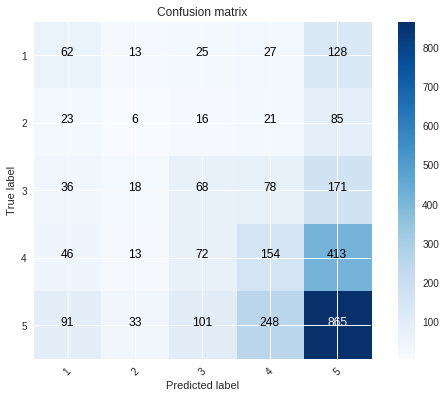

In [9]:
# print best estimator params
# best_parameters = grid_search.best_estimator_.get_params()
# for param_name in sorted(params.keys()):
#     print("\t%s: %r" % (param_name, best_parameters[param_name]))
# resultd evalution
# y_pred = grid_search.best_estimator_.predict(X_test)

y_pred = pipeline.predict(X_test)
print("F1 dummy most_frequent weighted score %f" % f1_score(y_test, y_pred, average='weighted'))
print("F1 dummy most_frequent macro score %f" % f1_score(y_test, y_pred, average='macro'))
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix,[1,2,3,4,5])

Macro score is 0.265831, weighted score is 0.388760.  
This is a little  better then dummy classifier macro score 0.212425 and weighted score 0.323443.  



## Artificial Neural Networks estimator

In ANN estimator keros framework have been used.  
CNN shows good results in DNN for image classifications, LSTM good for timeseries and queued events (like words in sentense) but in our case we have just array of features with unknown nature.  
So chosen architecture is relatively shallow set of fully connected layers interlaced by dropout layers.  
there are several parameters to play with: number of layers, size of layers, dropout value.  
Below  is result of our several tries to make effective architecture.

In [10]:
# crete X and y
X = df.iloc[:,1:-1].copy()
y = keras.utils.to_categorical(df['label'] - 1, num_classes=5)

# divide to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=3623467829)
# preprocess features
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
pca = PCA(n_components=512)
pca.fit(X_train)
X_train = pca.transform(X_train)

# balance train set
X_resampled, y_resampled = SMOTE().fit_sample(X_train, np.argmax(y_train, 1))
X_train = X_resampled
y_train = keras.utils.to_categorical(y_resampled, num_classes=5)
from collections import Counter
print(sorted(Counter(y_resampled).items()))


[(0, 12181), (1, 12181), (2, 12181), (3, 12181), (4, 12181)]


In [72]:
model = Sequential()
model.add(Dense(512, activation='relu', input_dim=512))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

model.fit(X_train, y_train,
          epochs=100,
          batch_size=128)



Epoch 1/100
60905/60905 [==============================] - 34s 562us/step - loss: 1.5242 - acc: 0.3137
Epoch 2/100
60905/60905 [==============================] - 32s 528us/step - loss: 1.4632 - acc: 0.3548
Epoch 3/100
60905/60905 [==============================] - 32s 531us/step - loss: 1.4081 - acc: 0.3930
Epoch 4/100
60905/60905 [==============================] - 32s 533us/step - loss: 1.3404 - acc: 0.4326
Epoch 5/100
60905/60905 [==============================] - 33s 537us/step - loss: 1.2728 - acc: 0.4654
Epoch 6/100
60905/60905 [==============================] - 33s 537us/step - loss: 1.2056 - acc: 0.4990
Epoch 7/100
60905/60905 [==============================] - 33s 538us/step - loss: 1.1464 - acc: 0.5230
Epoch 8/100
60905/60905 [==============================] - 32s 533us/step - loss: 1.0856 - acc: 0.5491
Epoch 9/100
60905/60905 [==============================] - 32s 523us/step - loss: 1.0366 - acc: 0.5707
Epoch 10/100
60905/60905 [==============================] - 32s 532us/ste

In [73]:
# make prediction on test set
X_test_2 = pca.transform(scaler.transform(X_test))

y_pred = model.predict(X_test_2)
# calculate f1 weighted score
score = model.evaluate(X_train, y_train, batch_size=128)
print("Score = %f" % score[1])
print("F1 weighted score %f" % f1_score(np.argmax(y_test, 1), np.argmax(y_pred, 1), average='weighted'))
print("F1 macro score %f" % f1_score(np.argmax(y_test, 1), np.argmax(y_pred, 1), average='macro'))

60905/60905 [==============================] - 8s 130us/step
Score = 0.996848
F1 weighted score 0.375937
F1 macro score 0.278116


Macro score is 0.278116, weighted score is 0.375937.  
This is a little  better then dummy classifier macro score 0.212425 and weighted score 0.323443.  



Confusion matrix, without normalization
[[ 73  25  38  54  65]
 [ 19  12  30  44  46]
 [ 32  19  80 107 133]
 [ 46  28 113 229 282]
 [ 65  49 196 385 643]]


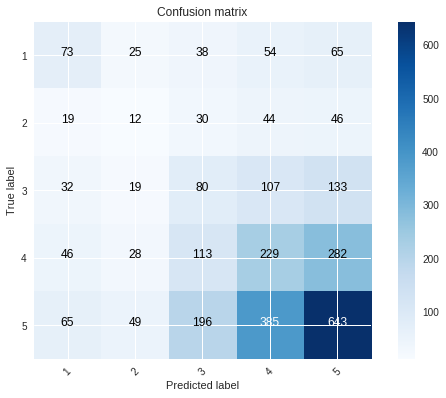

In [74]:
cnf_matrix = confusion_matrix(np.argmax(y_test, 1), np.argmax(y_pred, 1))
plot_confusion_matrix(cnf_matrix,[1,2,3,4,5])

Stacking binary classifiers with shallow multiclass classifier
===============================================

In [12]:
models = []
train_data = np.empty_like(y_train)
for i in range(0,5):  
  bmodel = Sequential()
  bmodel.add(Dense(512, activation='relu', input_dim=512))
  bmodel.add(Dropout(0.2))
  bmodel.add(Dense(1024, activation='relu'))
  bmodel.add(Dropout(0.2))
  bmodel.add(Dense(1024, activation='relu'))
  bmodel.add(Dropout(0.2))
  bmodel.add(Dense(512, activation='relu'))
  bmodel.add(Dropout(0.2))
  bmodel.add(Dense(1, activation='sigmoid'))
  sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
  bmodel.compile(loss='binary_crossentropy',
                optimizer=sgd,
                metrics=['accuracy'])
  bmodel.fit(X_train, (np.argmax(y_train, 1)==i)+0,
            epochs=30,
            batch_size=128)
  models.append(bmodel)
  r = bmodel.predict(X_train)
  train_data[:,i] = r.reshape(1, len(r))



Epoch 1/30
60905/60905 [==============================] - 31s 513us/step - loss: 0.4528 - acc: 0.8035
Epoch 2/30
60905/60905 [==============================] - 31s 507us/step - loss: 0.4185 - acc: 0.8148
Epoch 3/30
60905/60905 [==============================] - 31s 506us/step - loss: 0.3923 - acc: 0.8234
Epoch 4/30
60905/60905 [==============================] - 31s 509us/step - loss: 0.3668 - acc: 0.8341
Epoch 5/30
60905/60905 [==============================] - 31s 508us/step - loss: 0.3384 - acc: 0.8485
Epoch 6/30
60905/60905 [==============================] - 31s 507us/step - loss: 0.3086 - acc: 0.8612
Epoch 7/30
60905/60905 [==============================] - 31s 505us/step - loss: 0.2857 - acc: 0.8739
Epoch 8/30
60905/60905 [==============================] - 31s 503us/step - loss: 0.2617 - acc: 0.8856
Epoch 9/30
60905/60905 [==============================] - 30s 500us/step - loss: 0.2434 - acc: 0.8942
Epoch 10/30
60905/60905 [==============================] - 30s 493us/step - loss: 

In [43]:
mmodel = Sequential()
mmodel.add(Dense(5, activation='relu', input_dim=5))
mmodel.add(Dropout(0.2))
mmodel.add(Dense(10, activation='relu'))
mmodel.add(Dropout(0.2))
mmodel.add(Dense(5, activation='softmax'))

mmodel.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
mmodel.fit(train_data, y_train,
          epochs=20,
          batch_size=128)

Epoch 1/20
60905/60905 [==============================] - 2s 35us/step - loss: 1.1925 - acc: 0.5362
Epoch 2/20
60905/60905 [==============================] - 1s 17us/step - loss: 0.8011 - acc: 0.7037
Epoch 3/20
60905/60905 [==============================] - 1s 17us/step - loss: 0.6764 - acc: 0.7562
Epoch 4/20
60905/60905 [==============================] - 1s 16us/step - loss: 0.5962 - acc: 0.7863
Epoch 5/20
60905/60905 [==============================] - 1s 16us/step - loss: 0.5443 - acc: 0.8008
Epoch 6/20
60905/60905 [==============================] - 1s 16us/step - loss: 0.5226 - acc: 0.8104
Epoch 7/20
60905/60905 [==============================] - 1s 16us/step - loss: 0.5074 - acc: 0.8232
Epoch 8/20
60905/60905 [==============================] - 1s 17us/step - loss: 0.4948 - acc: 0.8277
Epoch 9/20
60905/60905 [==============================] - 1s 17us/step - loss: 0.4902 - acc: 0.8272
Epoch 10/20
60905/60905 [==============================] - 1s 18us/step - loss: 0.4834 - acc: 0.8281

In [0]:
# make prediction on test set
X_test_2 = pca.transform(scaler.transform(X_test))

test_data = np.empty_like(y_test)
for i in range(0,5):  
  r = models[i].predict(X_test_2)
  test_data[:,i] = r.reshape(1, len(r))

y_pred = mmodel.predict(test_data)

F1 weighted score 0.386277
F1 macro score 0.272772
Confusion matrix, without normalization
[[ 78  33  34  37  73]
 [ 29   9  24  35  54]
 [ 35  21  53 104 158]
 [ 51  20  94 221 312]
 [ 75  39 160 336 728]]


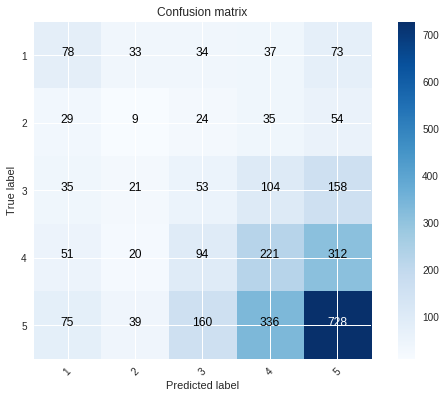

In [71]:
print("F1 weighted score %f" % f1_score(np.argmax(y_test, 1), np.argmax(y_pred, 1), average='weighted'))
print("F1 macro score %f" % f1_score(np.argmax(y_test, 1), np.argmax(y_pred, 1), average='macro'))
cnf_matrix = confusion_matrix(np.argmax(y_test, 1), np.argmax(y_pred, 1))
plot_confusion_matrix(cnf_matrix,[1,2,3,4,5])

Macro score is 0.272772, weighted score is 0.386277.  
This is a liittle better then dummy classifier macro score 0.212425 and weighted score 0.323443.  

# Conclusion

Following result have been achieved:


| Mode \ Target     |   Macro F1   |   Weighted F1  |  
| -------------------------   | ------------------: |  --------------------: |  
| SVM Classifier    |  0.265831     |       0.388760  |  
| ANN Classifier    |  0.278116     |       0.375937  |  
| Stacked Classifier    |  0.272772     |      0.386277  |  

SVM classifier shows best weighted f1 metric.  
ANN classifier shows best macro f1 metric.  

But all result not much better than dummy classifiers ( macro score 0.212425 and weighted score 0.323443).  
Cause of such a result may be week classifiers tuned during this work or absence of dependence between presented features and labels (which is indirectly confirmed by low correlation).  
Macto f1 metric is more general so ANN Classifier is the best for 5 classes.






# Future work
Presumably neural network approach can provide better results.  
Key development directions:  
1. Try deep architectures with [regularizers](https://keras.io/regularizers/)
1. Make CNN with convolutions based on 'fX__rY - groups of features. Convolutions in image classification extruct base features from 2d-local regions, so hypotheses  is to extract  base features of provided data from fX groups of features (that presumably grouped in some space)
1. Fit autoencoders on fX__rY groups of features and use them as input layer for 2-3 fully connected layers

# 2 classes classifier
Lets make ANN classifier for 2 classes dataset

In [0]:
# select 2 classes (1 and 5) subset
df2 = df[df['label'].isin([1, 5])].copy()
df2.loc[df2.label == 5, 'label'] = 2

# crete X and y
X = df2.iloc[:,1:-1].copy()
y = df2['label'] - 1

# divide to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=3623467829)

# preprocess features
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
pca = PCA(n_components=512)
pca.fit(X_train)
X_train = pca.transform(X_train)

# balance train set
# from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN
from collections import Counter
X_resampled, y_resampled = SMOTEENN().fit_sample(X_train, y_train)
X_train = X_resampled
y_train = y_resampled

In [23]:
# model
model = Sequential()
model.add(Dense(512, activation='relu', input_dim=512))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
model.fit(X_train, y_train, epochs=30, batch_size=128)

Epoch 1/30
18383/18383 [==============================] - 3s 158us/step - loss: 0.3947 - acc: 0.8194
Epoch 2/30
18383/18383 [==============================] - 2s 97us/step - loss: 0.2590 - acc: 0.8984
Epoch 3/30
18383/18383 [==============================] - 2s 97us/step - loss: 0.1720 - acc: 0.9365
Epoch 4/30
18383/18383 [==============================] - 2s 96us/step - loss: 0.1125 - acc: 0.9602
Epoch 5/30
18383/18383 [==============================] - 2s 97us/step - loss: 0.0881 - acc: 0.9696
Epoch 6/30
18383/18383 [==============================] - 2s 97us/step - loss: 0.0649 - acc: 0.9774
Epoch 7/30
18383/18383 [==============================] - 2s 97us/step - loss: 0.0484 - acc: 0.9828
Epoch 8/30
18383/18383 [==============================] - 2s 96us/step - loss: 0.0489 - acc: 0.9850
Epoch 9/30
18383/18383 [==============================] - 2s 96us/step - loss: 0.0383 - acc: 0.9881
Epoch 10/30
18383/18383 [==============================] - 2s 96us/step - loss: 0.0337 - acc: 0.988

F1  score 0.912137
Confusion matrix, without normalization
[[   5  255]
 [   2 1334]]


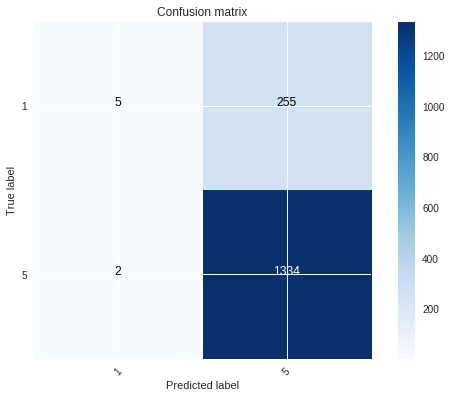

In [24]:
# make prediction on test set
X_test_2 = pca.transform(scaler.transform(X_test))
y_pred = model.predict(X_test_2)
y_pred = np.ceil(y_pred)
print("F1  score %f" % f1_score(y_test, y_pred))
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix,[1,5])

Dual classes classification shows better result f1=0.912449 
It is usual behavior cause 2 classes classification usually better and simpler than multiclass one.  
But still difference is too big.  
Possible cause that its data labeled by classes 2,3 for 4 natively belongs to 5 or 1. So estimator confused by that wrong data.  
Another explanation: presented set imbalanced in 5 class. Oversampling cannot absolutely remove this problem and estimator learn not only by features but it learn distribution of classes also. So when we present imbalanced test set skewed to 5 class estimator gives very good result.
The last explanation I believe most of all.


